<a href="https://colab.research.google.com/github/alisonnnnn88/programming_language/blob/main/HW3_%E6%8F%90%E6%AC%BE%E6%A9%9F%E7%B3%BB%E7%B5%B1(%E5%8C%AF%E5%85%A5%E5%8C%AF%E5%87%BA%E6%AA%94%E6%A1%88%E7%AD%89%E5%8A%9F%E8%83%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ==== 歡迎使用提款機系統 ====
📌 提款機系統使用說明
  
> 未使用過此系統之使用者，請點選【註冊】   
> 使用過則輸入帳密後點選【登入】    
> 登入後，按左上角【提款機功能】  

*   有以下幾個按鍵:新增存款金額、新增提款金額、查看餘額、登出
*   若要輸入存款 or 提款，請輸入完數字後，點選【新增存款/提款金額】
*   【提款機功能頁面】最底下會顯示操作結果 (如:✅ 已新增收入：200 元)
*   若要轉帳，請輸入完目標帳號和金額後，點選【轉帳】   
*   若要查看餘額，請點選【查看餘額】

> 接著如果想查看提款機記錄，按最上面的【提款機紀錄】  

*   有以下幾個按鍵:篩選日期、刷新紀錄、清除紀錄、匯入匯出紀錄
*   若要查看最新提款機紀錄，請按【刷新紀錄】
*   若只想查看某一時段的紀錄，請按照格式(yyyy-mm-dd)輸入，再按【刷新紀錄】
*   若想完全清除提款機紀錄，請點選【清除紀錄】
*   若要匯入檔案，請點選【上傳csv檔案】，【匯入紀錄】
*   若要匯出檔案，則按【匯出紀錄】，再滑到頁面下方的匯出結果下載檔案

> 接著如果想查看提款機記錄的圖表統整，按最上面的【視覺化統計】

*   有以下幾個按鍵:篩選日期、生成統計圖表
*   若要查看整個紀錄的圖表，請按【生成統計圖表】
*   若只想查看某一時段的紀錄，請按照格式(yyyy-mm-dd)輸入，再按【生成統計圖表】
*   分別會生成餘額變化折線圖、交易趨勢長條圖、交易比例圓餅圖

> 溫馨提醒:  
> 清除紀錄後 ⚠️不可復原⚠️   
> 支出時若金額超過餘額，會顯示「餘額不足」  


💵 提款紀錄: https://docs.google.com/spreadsheets/d/1h75idXVO6GMosL5bPUF-G76MqxOziHu1tJieRtpdkP4/edit?usp=sharing

In [1]:
!pip install gradio google-generativeai --upgrade
!pip install plotly

In [2]:
import gradio as gr
import gspread
from google.colab import auth
from google.auth import default
from datetime import datetime
import pytz
import pandas as pd
import io
import tempfile
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

In [3]:
# --- Google Sheets ---
# Google 認證 (Colab 專用)
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# 設定 Google Sheets URL 和工作表
SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/1h75idXVO6GMosL5bPUF-G76MqxOziHu1tJieRtpdkP4/edit?usp=sharing"
sh = gc.open_by_url(SPREADSHEET_URL)

# 工作表設定
user_ws = sh.worksheet("使用者資料表")
record_ws = sh.worksheet("交易紀錄表")
ai_ws = sh.worksheet("AI建議紀錄")

# 設定登入系統
current_user = None

# --- 核心功能函數 ---

def handle_register(username, password):
    users = [str(u).strip() for u in user_ws.col_values(1) if u is not None]
    if username in users:
        return "⚠️ 帳號已存在"
    else:
        user_ws.append_row([username, password])
        return f"✅ 註冊成功，請登入"

def handle_login(username, password):
    global current_user
    users_dict = {str(row['使用者名稱']).strip(): str(row['密碼']).strip()
                  for row in user_ws.get_all_records() if row['使用者名稱'] is not None}

    if username in users_dict and users_dict[username] == password:
        current_user = username
        return f"✅ 登入成功，歡迎 {username}！\n請選擇操作"
    else:
        return "❌ 帳號或密碼錯誤"

def handle_income(income):
    if current_user is None:
        return "❌ 請先登入"
    if int(income) <= 0:
        return "❌ 輸入金額需大於0，請重新輸入"
    tz = pytz.timezone("Asia/Taipei")
    now = datetime.now(tz)
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    previous_balance = float(user_df.iloc[-1]["餘額"]) if not user_df.empty else 0.0
    new_balance = previous_balance + int(income)
    record_ws.append_row([current_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                          int(income), 0, 0, new_balance])
    return f"✅ 已新增存款金額：{income} 元"

def handle_expense(expense):
    if current_user is None:
        return "❌ 請先登入"
    amount = int(expense)
    if amount <= 0:
        return "❌ 輸入金額需大於0，請重新輸入"
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    balance = float(user_df.iloc[-1]["餘額"]) if not user_df.empty else 0.0
    if amount > balance:
        return "❌ 餘額不足！"
    else:
        tz = pytz.timezone("Asia/Taipei")
        now = datetime.now(tz)
        new_balance = balance - amount
        record_ws.append_row([current_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                              0, amount, 0, new_balance])
        return f"✅ 已新增提款金額：{amount} 元"

def handle_balance():
    if current_user is None:
        return "❌ 請先登入"
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    balance = int(float(user_df.iloc[-1]["餘額"])) if not user_df.empty else 0
    return f"💰 您目前的餘額為：{balance} 元"

def handle_transfer(target_user, amount):
    global current_user
    if current_user is None:
        return "❌ 請先登入"

    # 金額檢查
    amount = int(amount)
    if amount <= 0:
        return "❌ 轉帳金額需大於0，請重新輸入"

    # 確認目標帳號存在
    users = [str(u).strip() for u in user_ws.col_values(1) if u is not None]
    if target_user not in users:
        return "❌ 目標帳號不存在，請確認帳號是否正確"

    # 取出目前使用者餘額
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user] if not df.empty else pd.DataFrame()
    balance = float(user_df.iloc[-1]["餘額"]) if not user_df.empty else 0.0

    if amount > balance:
        return "❌ 餘額不足，無法轉帳"

    # 時間戳記
    tz = pytz.timezone("Asia/Taipei")
    now = datetime.now(tz)

    # 更新轉出者餘額
    new_balance_sender = balance - amount
    record_ws.append_row([current_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                          0, 0, amount, new_balance_sender])  # 👈 存款=0, 提款=0, 轉帳=金額

    # 更新收款者餘額
    target_df = df[df["使用者名稱"] == target_user] if not df.empty else pd.DataFrame()
    target_balance = float(target_df.iloc[-1]["餘額"]) if not target_df.empty else 0.0
    new_balance_receiver = target_balance + amount
    record_ws.append_row([target_user, now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"),
                          amount, 0, 0, new_balance_receiver])  # 👈 存款=金額, 其他=0

    return f"✅ 轉帳成功！您已轉出 {amount} 元給 {target_user}\n💰 您的新餘額為：{int(new_balance_sender)} 元"

def handle_clear():
    global current_user
    if current_user is None:
        return "❌ 請先登入"
    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
    new_df = df[df["使用者名稱"] != current_user] if not df.empty else pd.DataFrame()
    record_ws.clear()
    record_ws.append_row(["使用者名稱", "日期", "時間", "存款", "提款", "轉帳", "餘額"])
    for row in new_df.values.tolist():
        record_ws.append_row(row)
    return "🗑️ 已清除您的所有紀錄"

def handle_logout():
    global current_user
    current_user = None
    return "👋 已登出！請重新登入"

def handle_records_with_date(start_date, end_date):
    """依照時間範圍篩選目前使用者的交易紀錄"""
    if current_user is None:
        return pd.DataFrame([["❌ 請先登入"]], columns=["訊息"])

    df = pd.DataFrame(record_ws.get_all_records())
    if df.empty:
        return pd.DataFrame([["尚無紀錄"]], columns=["訊息"])

    df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user]

    if user_df.empty:
        return pd.DataFrame([["尚無紀錄"]], columns=["訊息"])

    # 合併日期與時間
    user_df["日期時間"] = pd.to_datetime(
        user_df["日期"].astype(str).str.strip() + " " + user_df["時間"].astype(str).str.strip(),
        errors="coerce"
    )

    # 篩選日期範圍
    if start_date:
        try:
            start = pd.to_datetime(start_date)
            user_df = user_df[user_df["日期時間"] >= start]
        except:
            pass
    if end_date:
        try:
            end = pd.to_datetime(end_date)
            user_df = user_df[user_df["日期時間"] <= end]
        except:
            pass

    if user_df.empty:
        return pd.DataFrame([["⚠️ 此日期區間無交易紀錄"]], columns=["訊息"])

    return user_df[["日期", "時間", "存款", "提款", "轉帳", "餘額"]]


def handle_export_csv():
    """匯出目前使用者的交易紀錄成 CSV 檔案"""
    if current_user is None:
        return None, "❌ 請先登入才能匯出紀錄。"

    df = pd.DataFrame(record_ws.get_all_records())
    if not df.empty:
        df.columns = df.columns.str.strip()
        user_df = df[df["使用者名稱"] == current_user]
    else:
        user_df = pd.DataFrame()

    if user_df.empty:
        return None, "📝 尚無可匯出的紀錄。"

    # 建立暫存檔
    with tempfile.NamedTemporaryFile(delete=False, suffix=".csv", mode="w", encoding="utf-8-sig") as tmpfile:
        user_df.to_csv(tmpfile.name, index=False, encoding="utf-8-sig")
        tmp_path = tmpfile.name

    return tmp_path, f"✅ 已匯出 {len(user_df)} 筆紀錄！"

def handle_import_csv(file):
    """從上傳的 CSV 檔新增紀錄到試算表"""
    if current_user is None:
        return "❌ 請先登入才能匯入紀錄。"
    if file is None:
        return "⚠️ 請先上傳 CSV 檔案。"

    try:
        df_new = pd.read_csv(file.name)

        # 確保欄位完整
        required_cols = {"日期", "時間", "存款", "提款", "轉帳", "餘額"}
        if not required_cols.issubset(df_new.columns):
            return "⚠️ CSV 欄位錯誤，請確認包含「日期、時間、存款、提款、轉帳、餘額」"

        # 補上使用者名稱欄位
        df_new["使用者名稱"] = current_user

        # 將空值補為 0，並確保數值安全
        for col in ["存款", "提款", "轉帳", "餘額"]:
            df_new[col] = pd.to_numeric(df_new[col], errors="coerce").fillna(0)

        # 寫入試算表（逐列處理，避免 JSON 不合規）
        for _, row in df_new.iterrows():
            record_ws.append_row([
                str(row["使用者名稱"]),
                str(row["日期"]),
                str(row["時間"]),
                float(row["存款"]),
                float(row["提款"]),
                float(row["轉帳"]),
                float(row["餘額"])
            ], value_input_option="USER_ENTERED")

        return f"✅ 已成功匯入 {len(df_new)} 筆紀錄。"

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"❌ 匯入失敗：{e}"


def handle_visualization_with_date(start_date, end_date):
    """根據時間範圍視覺化目前使用者的交易紀錄 (使用 Seaborn)"""
    if current_user is None:
        return "❌ 請先登入才能查看統計圖表。", None, None, None

    # 取得紀錄
    df = pd.DataFrame(record_ws.get_all_records())
    if df.empty:
        return "📝 尚無交易紀錄。", None, None, None

    df.columns = df.columns.str.strip()
    user_df = df[df["使用者名稱"] == current_user]
    if user_df.empty:
        return "📝 尚無您的交易紀錄。", None, None, None

    # 將日期與時間合併成 datetime
    user_df["日期時間"] = pd.to_datetime(
        user_df["日期"].astype(str) + " " + user_df["時間"].astype(str),
        errors="coerce"
    )

    # 篩選日期範圍
    if start_date:
        try:
            start = pd.to_datetime(start_date)
            user_df = user_df[user_df["日期時間"] >= start]
        except:
            pass
    if end_date:
        try:
            end = pd.to_datetime(end_date)
            user_df = user_df[user_df["日期時間"] <= end]
        except:
            pass

    if user_df.empty:
        return "📅 此日期區間內無交易紀錄。", None, None, None

    # ====== 中文字體設定 ======
    #plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
    #plt.rcParams['axes.unicode_minus'] = False

    # ====== 生成餘額變化折線圖 ======
    fig1, ax1 = plt.subplots(figsize=(10,5))
    sns.lineplot(data=user_df, x='日期時間', y='餘額', marker='o', ax=ax1)
    ax1.set_title("Balance change chart")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Balance ($)")
    ax1.tick_params(axis='x', rotation=45)

    # ====== 生成交易趨勢長條圖 ======
    user_melt = user_df.melt(id_vars=['日期時間'], value_vars=['存款','提款','轉帳'],
                            var_name='交易類型', value_name='金額')

    # 提款和轉帳顯示負值
    user_melt.loc[user_melt['交易類型'].isin(['提款','轉帳']), '金額'] *= -1

    # 將交易類型轉為英文（在畫圖前做）
    user_melt['交易類型'] = user_melt['交易類型'].replace({
      '存款': 'Deposit',
      '提款': 'Withdrawal',
      '轉帳': 'Transfer'
    })

    # 繪製條形圖
    fig2, ax2 = plt.subplots(figsize=(10,5))
    sns.barplot(data=user_melt, x='日期時間', y='金額', hue='交易類型', ax=ax2)

    ax2.set_title("Trading trend chart")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Balance ($)")
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(title="Transaction Type")

    # ====== 生成交易比例圓餅圖 ======
    total_income = user_df["存款"].sum()
    total_expense = user_df["提款"].sum()
    total_transfer = user_df["轉帳"].sum()
    labels = ["Deposit", "Withdrawal", "Transfer"]
    sizes = [total_income, total_expense, total_transfer]

    fig3, ax3 = plt.subplots(figsize=(6,6))
    ax3.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax3.set_title("Transaction ratio pie chart")

    return "✅ 已生成交易統計圖表！", fig1, fig2, fig3

In [ ]:
# --- Gradio UI 介面 ---
def gradio_interface():
    with gr.Blocks(title="Gradio 銀行記帳系統 (整合 AI 顧問)") as demo:
        user_status = gr.State(current_user)

        with gr.Tab("登入/註冊"):
            with gr.Row():
                username_input = gr.Textbox(label="帳號")
                password_input = gr.Textbox(label="密碼", type="password")
            with gr.Row():
                login_btn = gr.Button("登入")
                register_btn = gr.Button("註冊")
            output_login = gr.Textbox(label="登入結果")

            login_btn.click(handle_login, inputs=[username_input, password_input], outputs=output_login).then(
                lambda: current_user, None, user_status
            )
            register_btn.click(handle_register, inputs=[username_input, password_input], outputs=output_login)

        with gr.Tab("提款機功能"):
            balance_btn = gr.Button("查看餘額")
            income_input = gr.Number(label="存款金額")
            income_btn = gr.Button("新增存款金額")
            expense_input = gr.Number(label="提款金額")
            expense_btn = gr.Button("新增提款金額")

            # 轉帳功能
            target_user_input = gr.Textbox(label="轉帳目標帳號")
            transfer_input = gr.Number(label="轉帳金額")
            transfer_btn = gr.Button("轉帳")

            logout_btn = gr.Button("登出")
            output = gr.Textbox(label="操作結果")

            balance_btn.click(handle_balance, outputs=output)
            income_btn.click(handle_income, inputs=[income_input], outputs=output)
            expense_btn.click(handle_expense, inputs=[expense_input], outputs=output)
            transfer_btn.click(handle_transfer, inputs=[target_user_input, transfer_input], outputs=output)
            logout_btn.click(handle_logout, outputs=output)

        with gr.Tab("提款機紀錄"):
          # 🗓️ 日期篩選
          with gr.Row():
              start_date_rec = gr.Textbox(label="起始日期 (YYYY-MM-DD)")
              end_date_rec = gr.Textbox(label="結束日期 (YYYY-MM-DD)")

          # 刷新紀錄按鈕 + 表格
          records_btn = gr.Button("刷新紀錄")
          records_table = gr.Dataframe(
              headers=["使用者名稱", "日期", "時間", "存款", "提款", "轉帳", "餘額"],
              label="交易紀錄"
          )
          records_btn.click(
              handle_records_with_date,  # 新增日期篩選函式
              inputs=[start_date_rec, end_date_rec],
              outputs=records_table
          )

          # 清除記錄
          clear_btn = gr.Button("清除紀錄")
          clear_btn.click(handle_clear, outputs=output)

          # 匯入 / 匯出功能
          gr.Markdown("### 📂 匯入 / 匯出功能")
          with gr.Row():
              import_file = gr.File(label="上傳 CSV 檔案")
              import_btn = gr.Button("匯入紀錄")
              export_btn = gr.Button("匯出紀錄")

          import_output = gr.Textbox(label="匯入結果")
          export_file = gr.File(label="下載檔案", interactive=False)
          export_output = gr.Textbox(label="匯出結果")

          # 綁定事件
          import_btn.click(handle_import_csv, inputs=[import_file], outputs=import_output)
          export_btn.click(handle_export_csv, outputs=[export_file, export_output])


        # 📊 視覺化統計（可篩選日期）
        with gr.Tab("📈 視覺化統計"):
            gr.Markdown("### 📊 交易視覺化（可篩選日期）")

            with gr.Row():
                start_date = gr.Textbox(label="起始日期 (YYYY-MM-DD)", placeholder="例如：2025-10-01")
                end_date = gr.Textbox(label="結束日期 (YYYY-MM-DD)", placeholder="例如：2025-10-09")

            gen_btn = gr.Button("生成統計圖表")

            output_text = gr.Textbox(label="系統訊息")
            balance_plot = gr.Plot(label="Balance change chart")   #餘額變化圖
            trend_plot = gr.Plot(label="Trading trend chart")   #交易趨勢圖
            pie_plot = gr.Plot(label="Transaction ratio pie chart")    #交易比例圓餅圖

            # 將 Seaborn 圖表轉給 Gradio
            def generate_visualization(start_date, end_date):
                msg, fig_balance, fig_trend, fig_pie = handle_visualization_with_date(start_date, end_date)

                figs = []
                for fig in [fig_balance, fig_trend, fig_pie]:
                    if fig is not None:
                        fig.canvas.draw()  # 確保圖表更新
                        figs.append(fig)
                    else:
                        figs.append(None)

                return [msg] + figs

            gen_btn.click(
                fn=generate_visualization,
                inputs=[start_date, end_date],
                outputs=[output_text, balance_plot, trend_plot, pie_plot]
            )

    return demo

# 啟動 Gradio 應用
demo = gradio_interface()
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fc62271b59e6821c2c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1228961526.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df["日期時間"] = pd.to_datetime(
/tmp/ipython-input-1228961526.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df["日期時間"] = pd.to_datetime(
/tmp/ipython-input-1228961526.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

匯出檔案
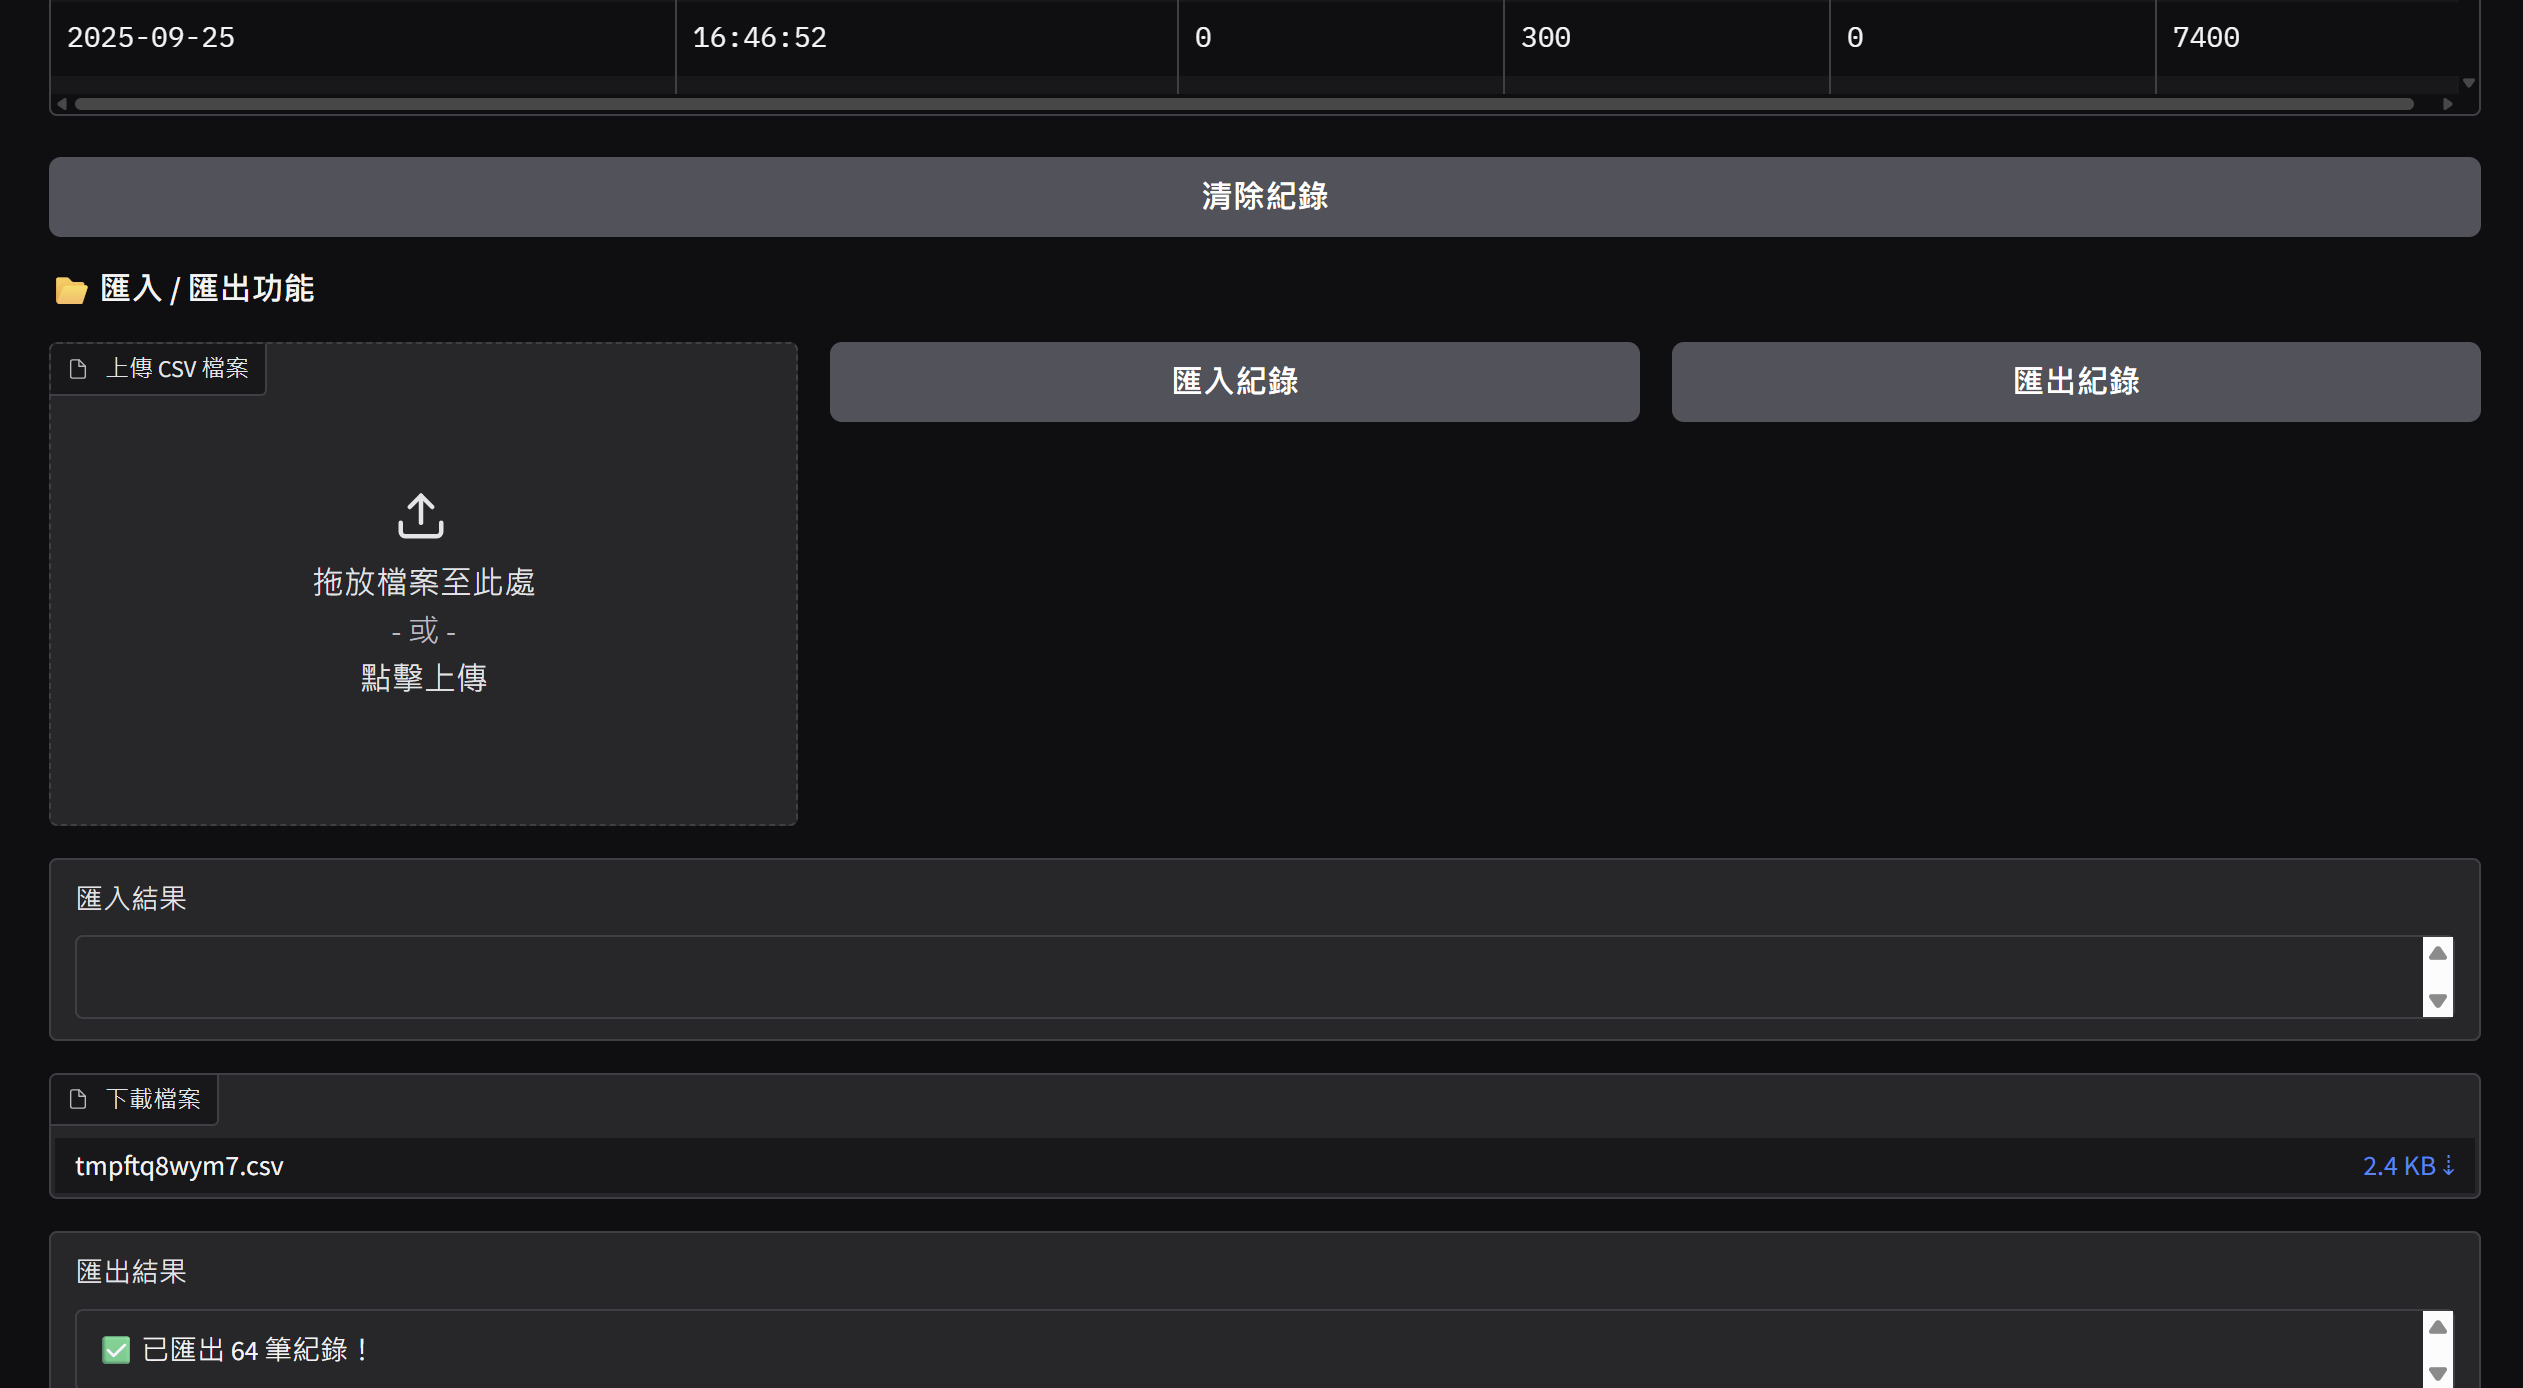
匯入檔案
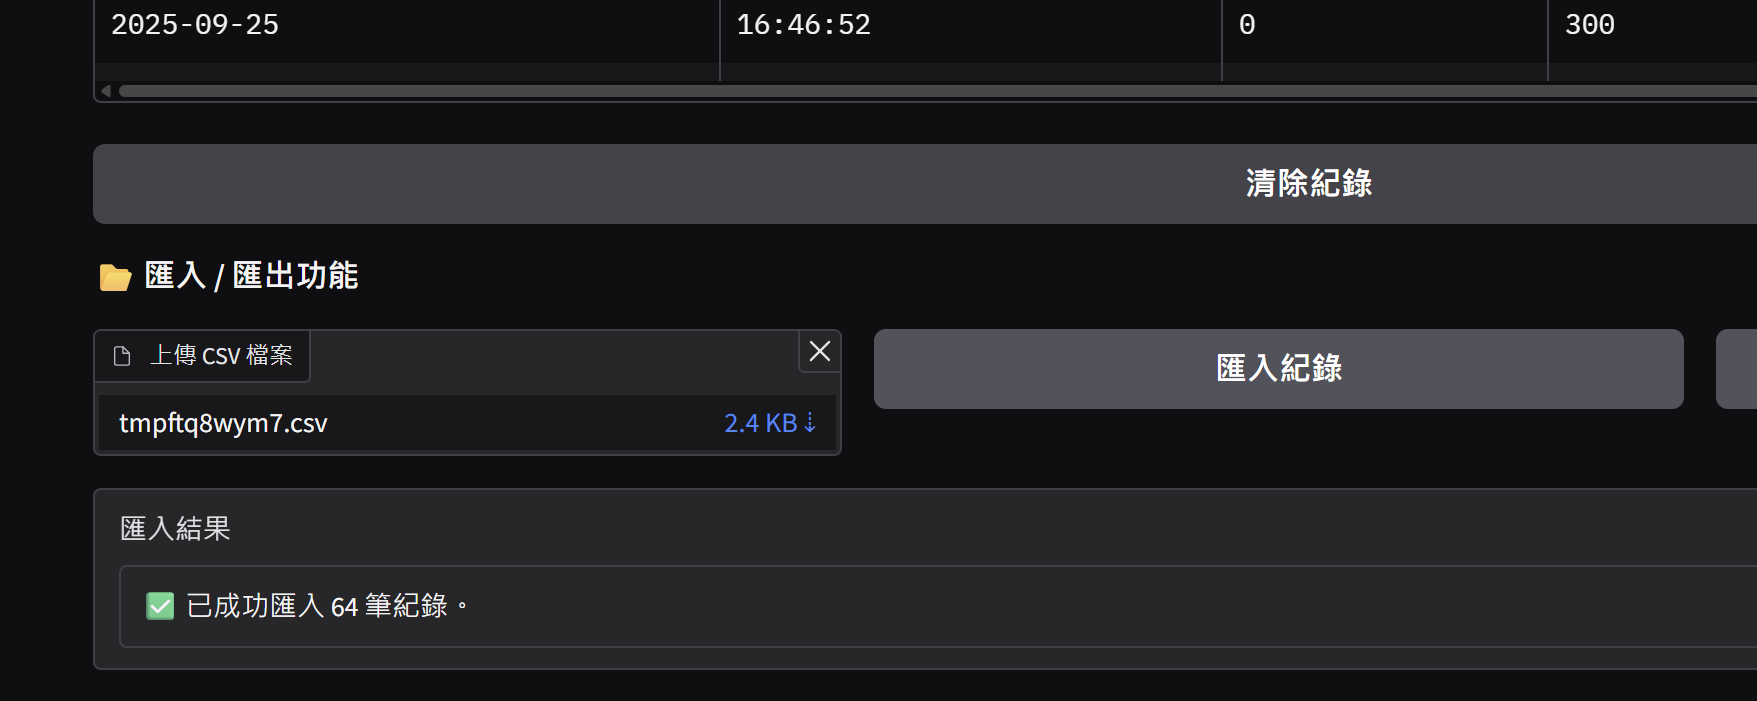
選擇開始與結束日期-提款機紀錄(結束日只記到結束日期前一天，也就是假如結束日期是9/26，是記到9/25之前的紀錄)
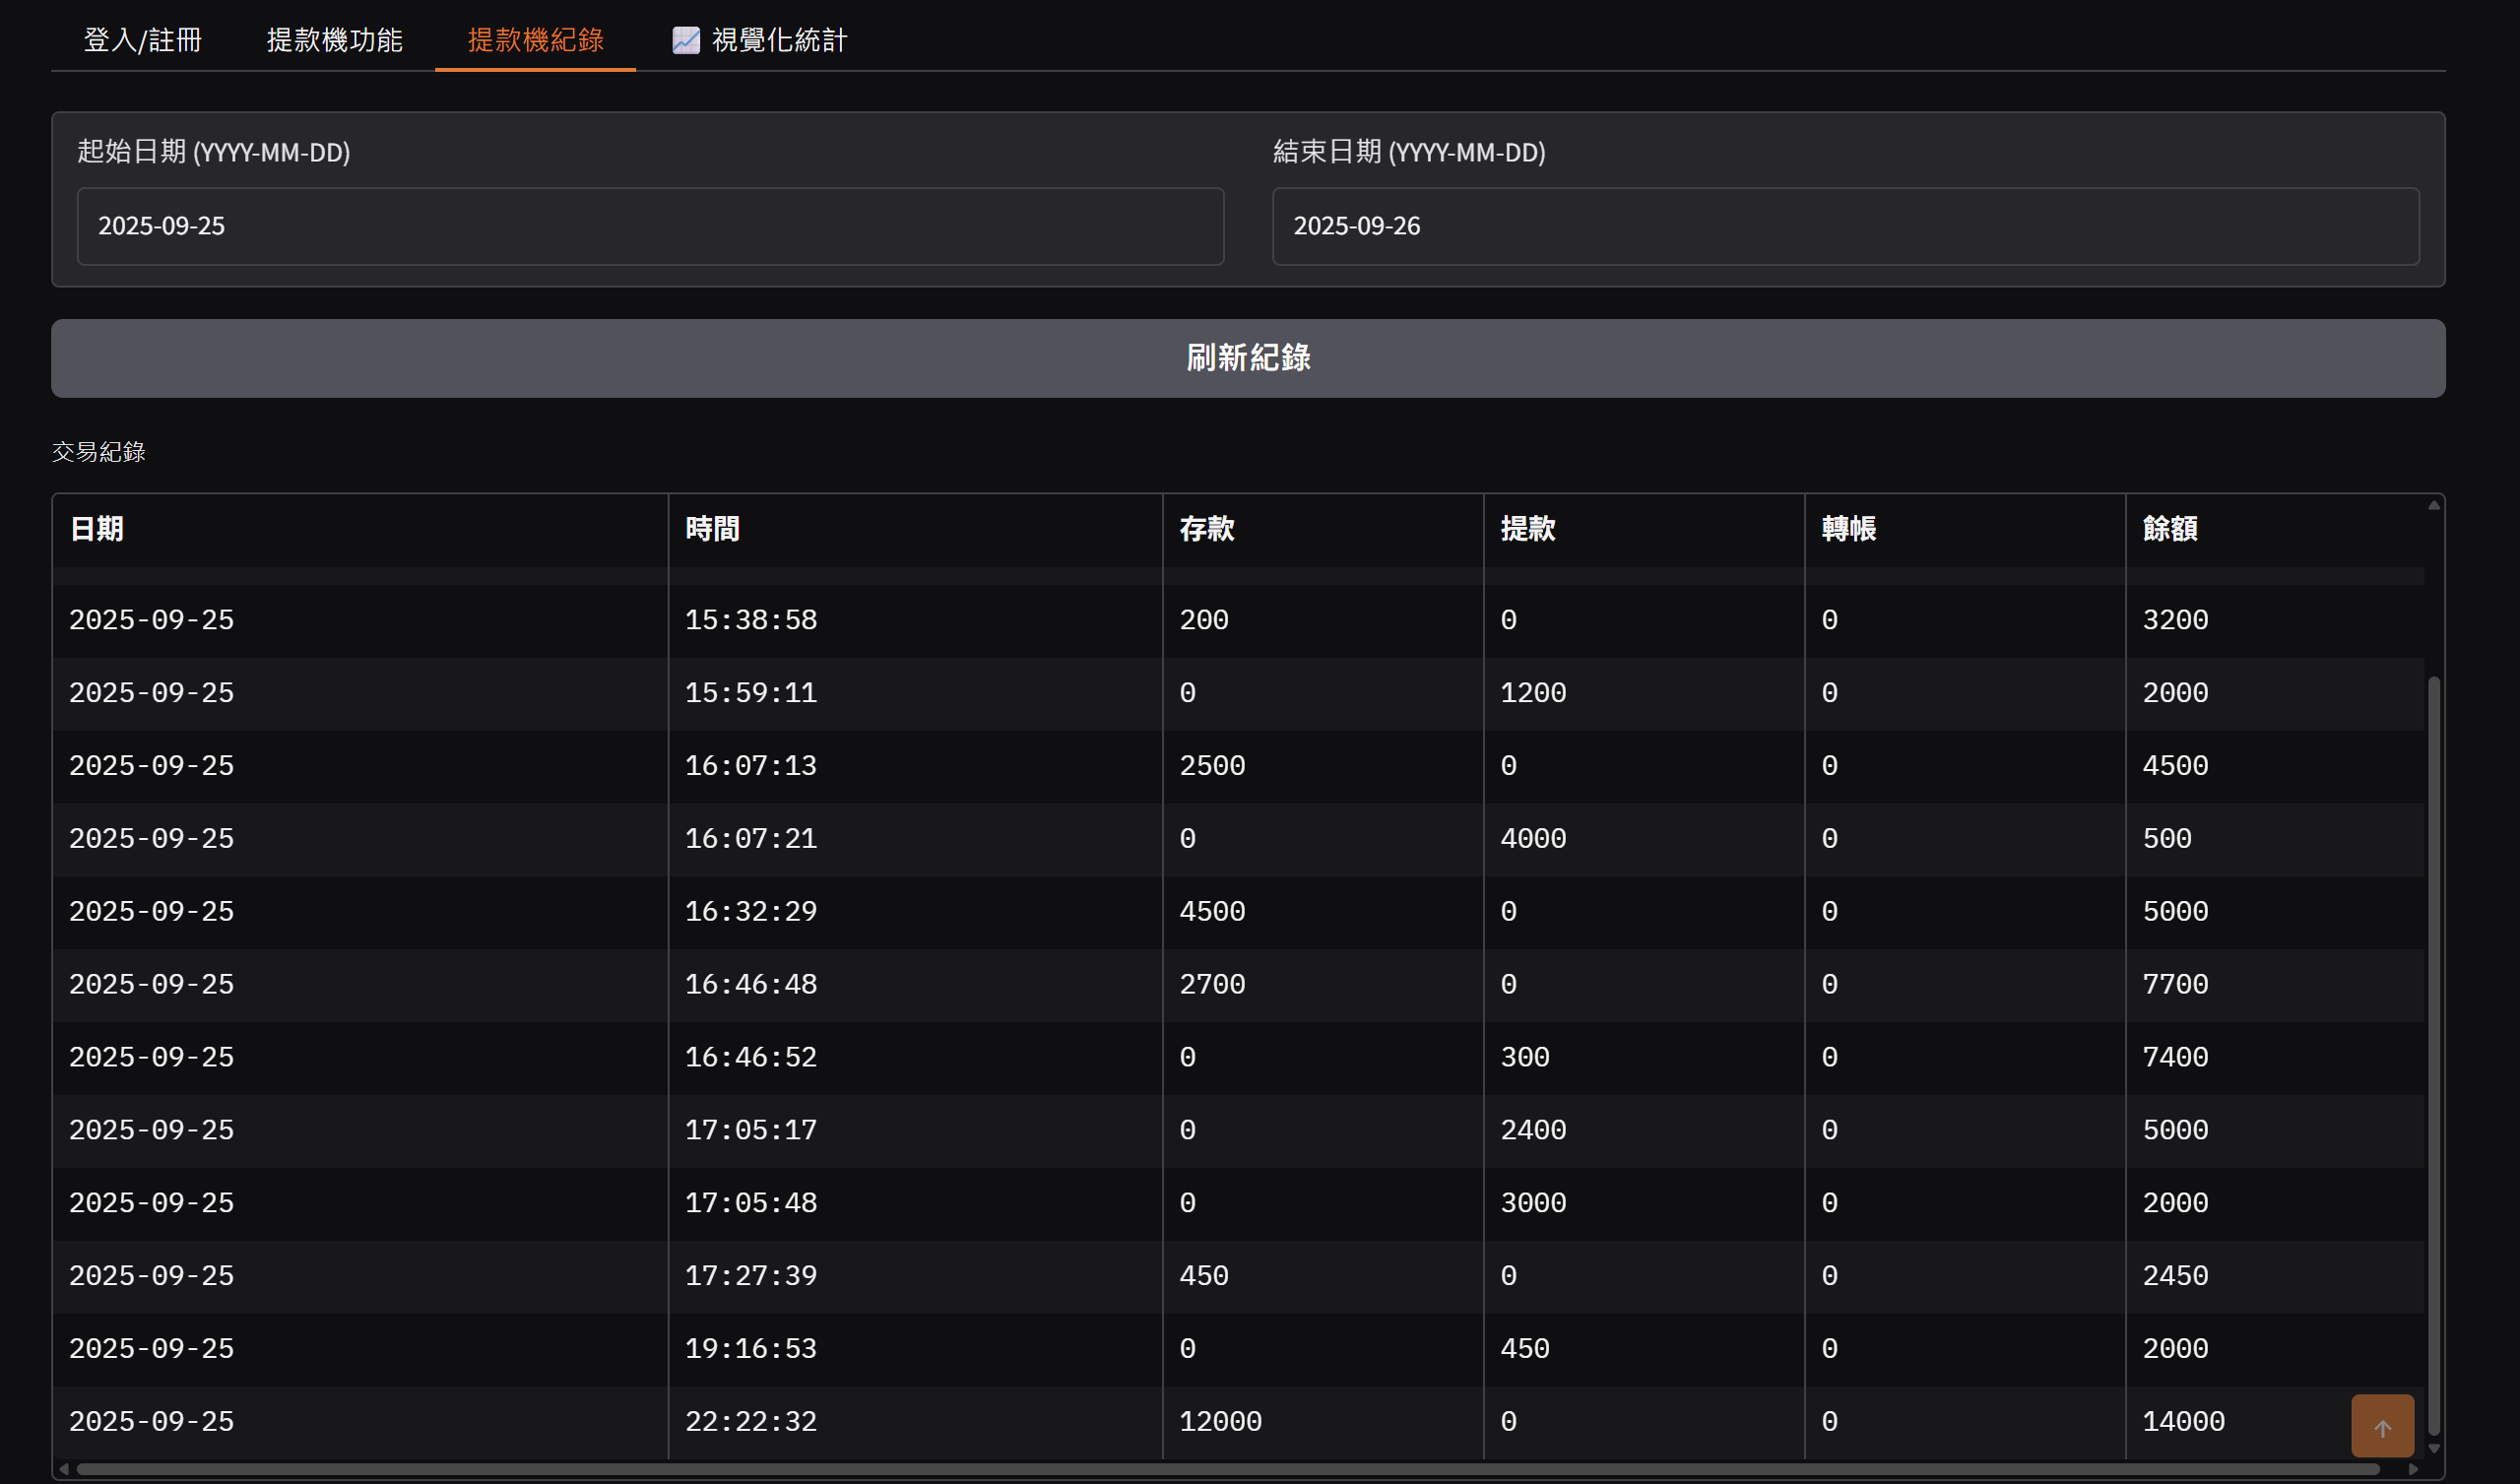
生成統計圖表
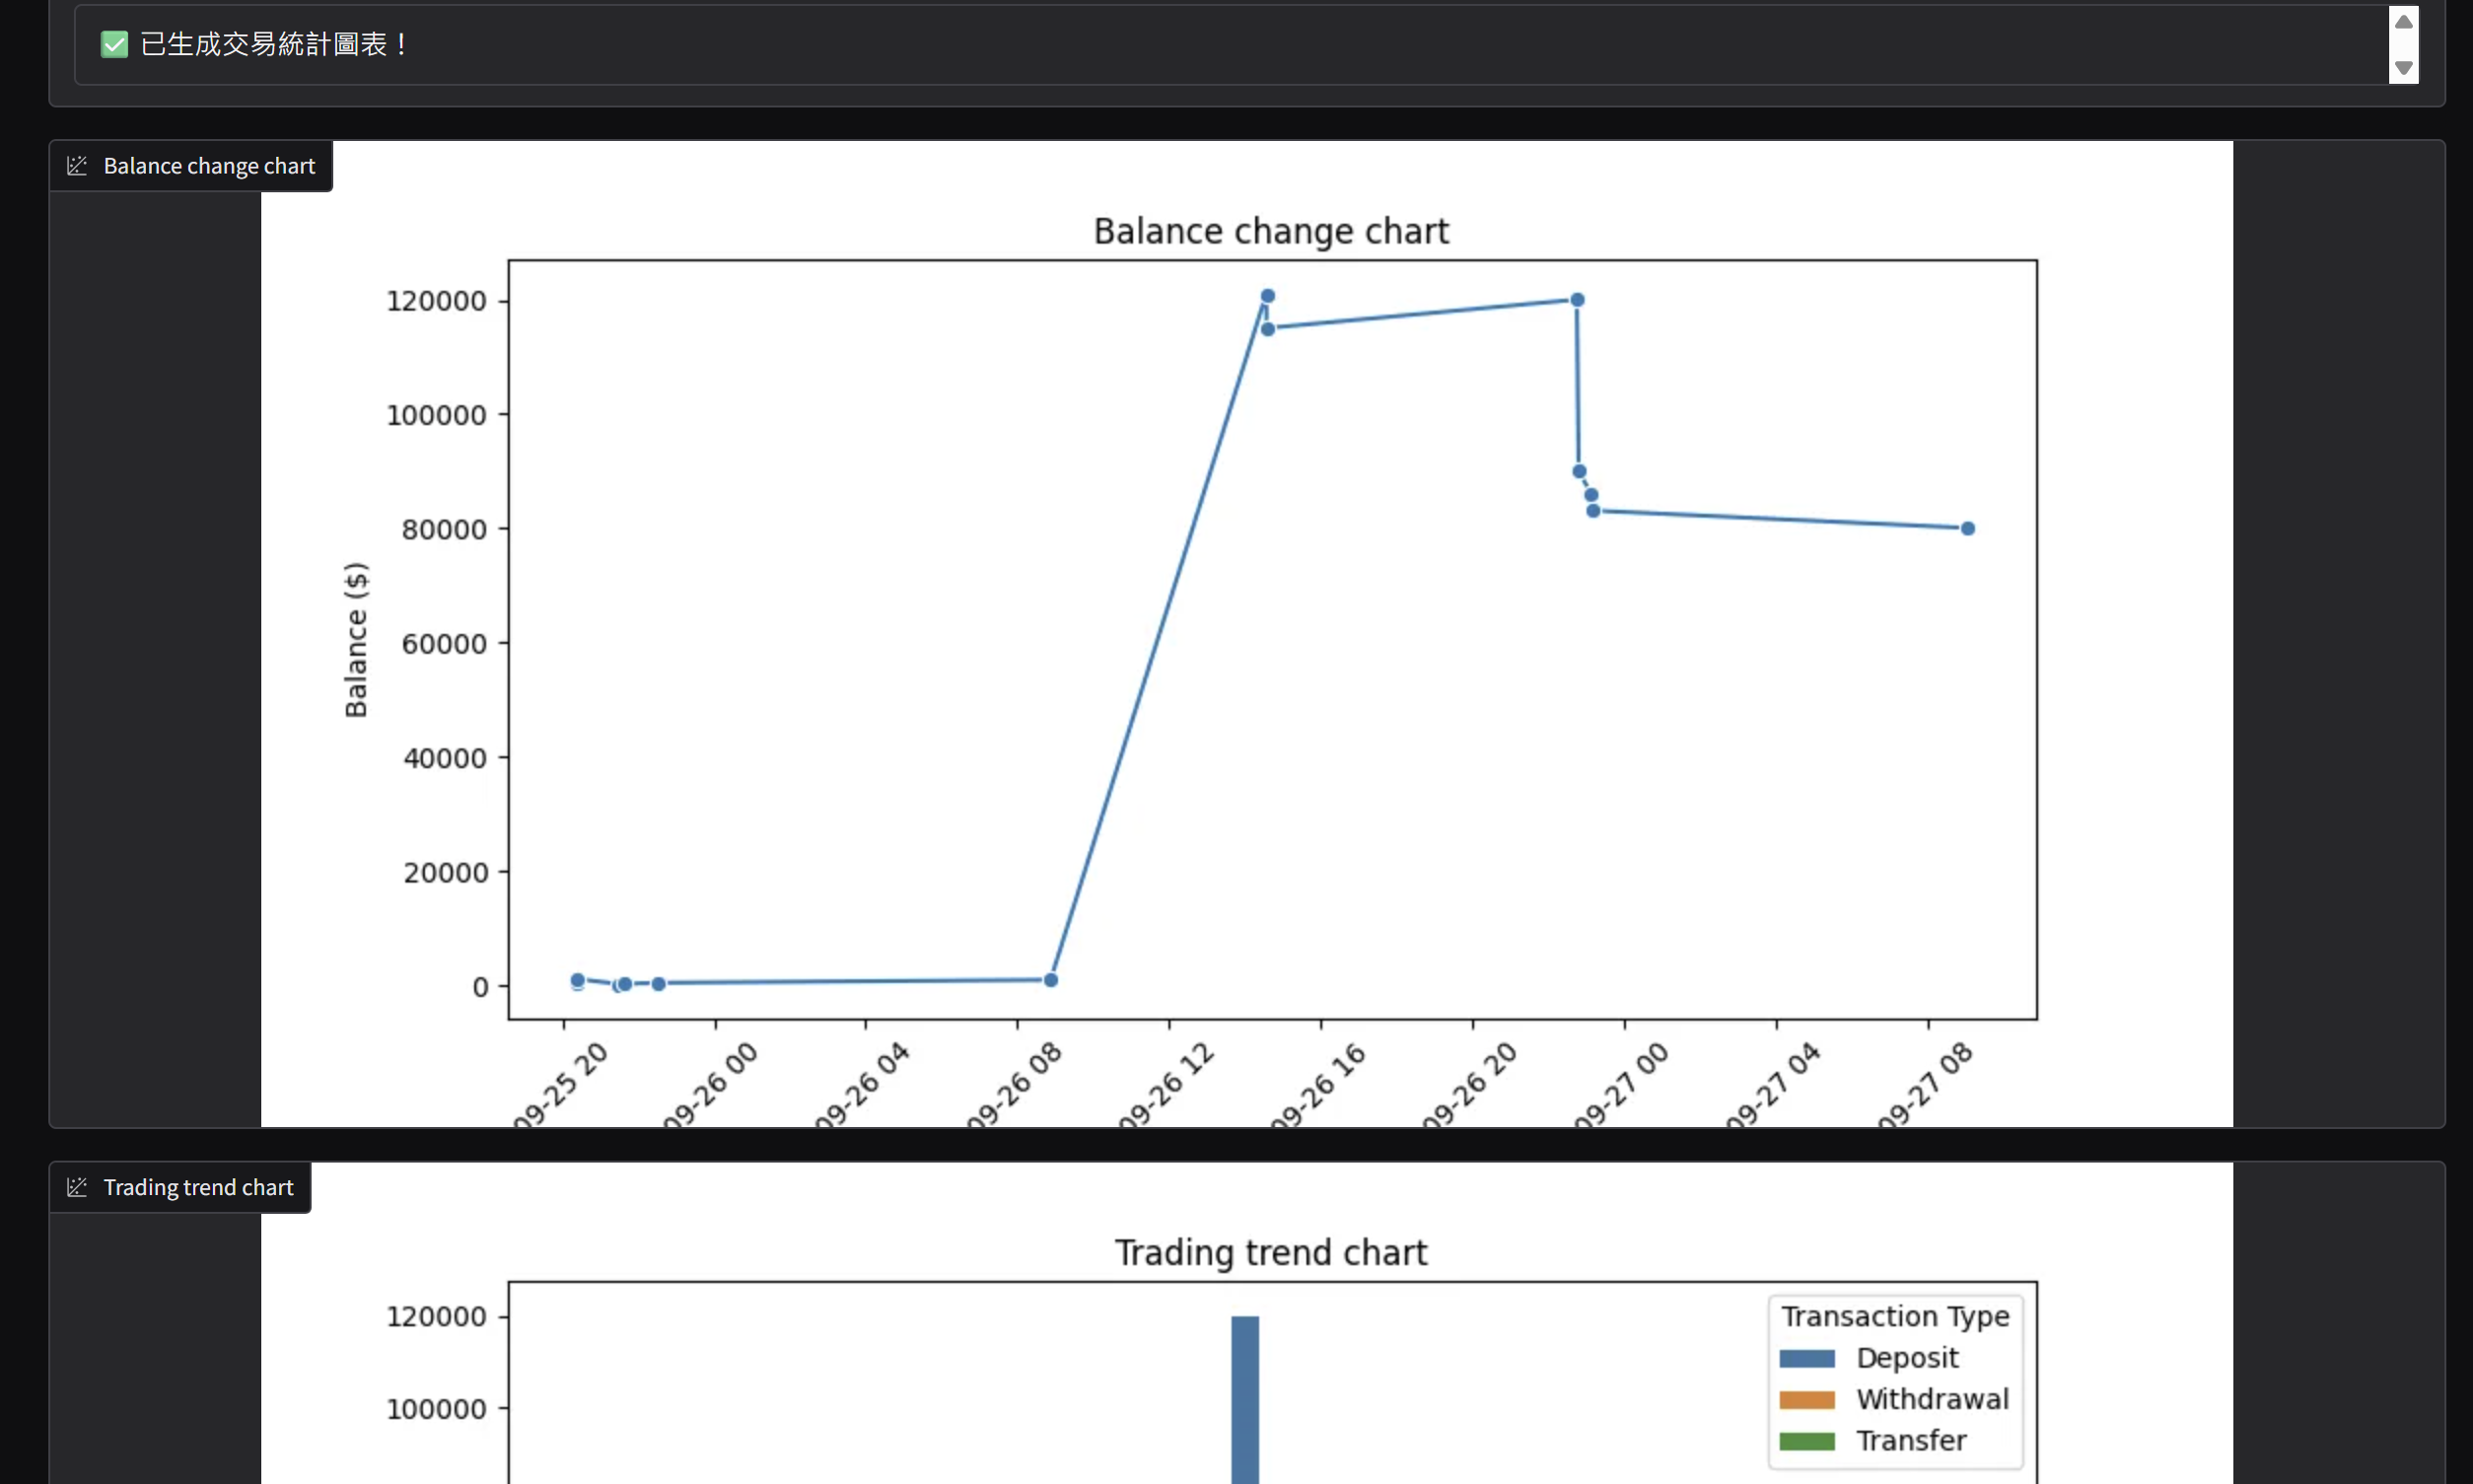
和提款機記錄一樣可以篩選日期印出圖表
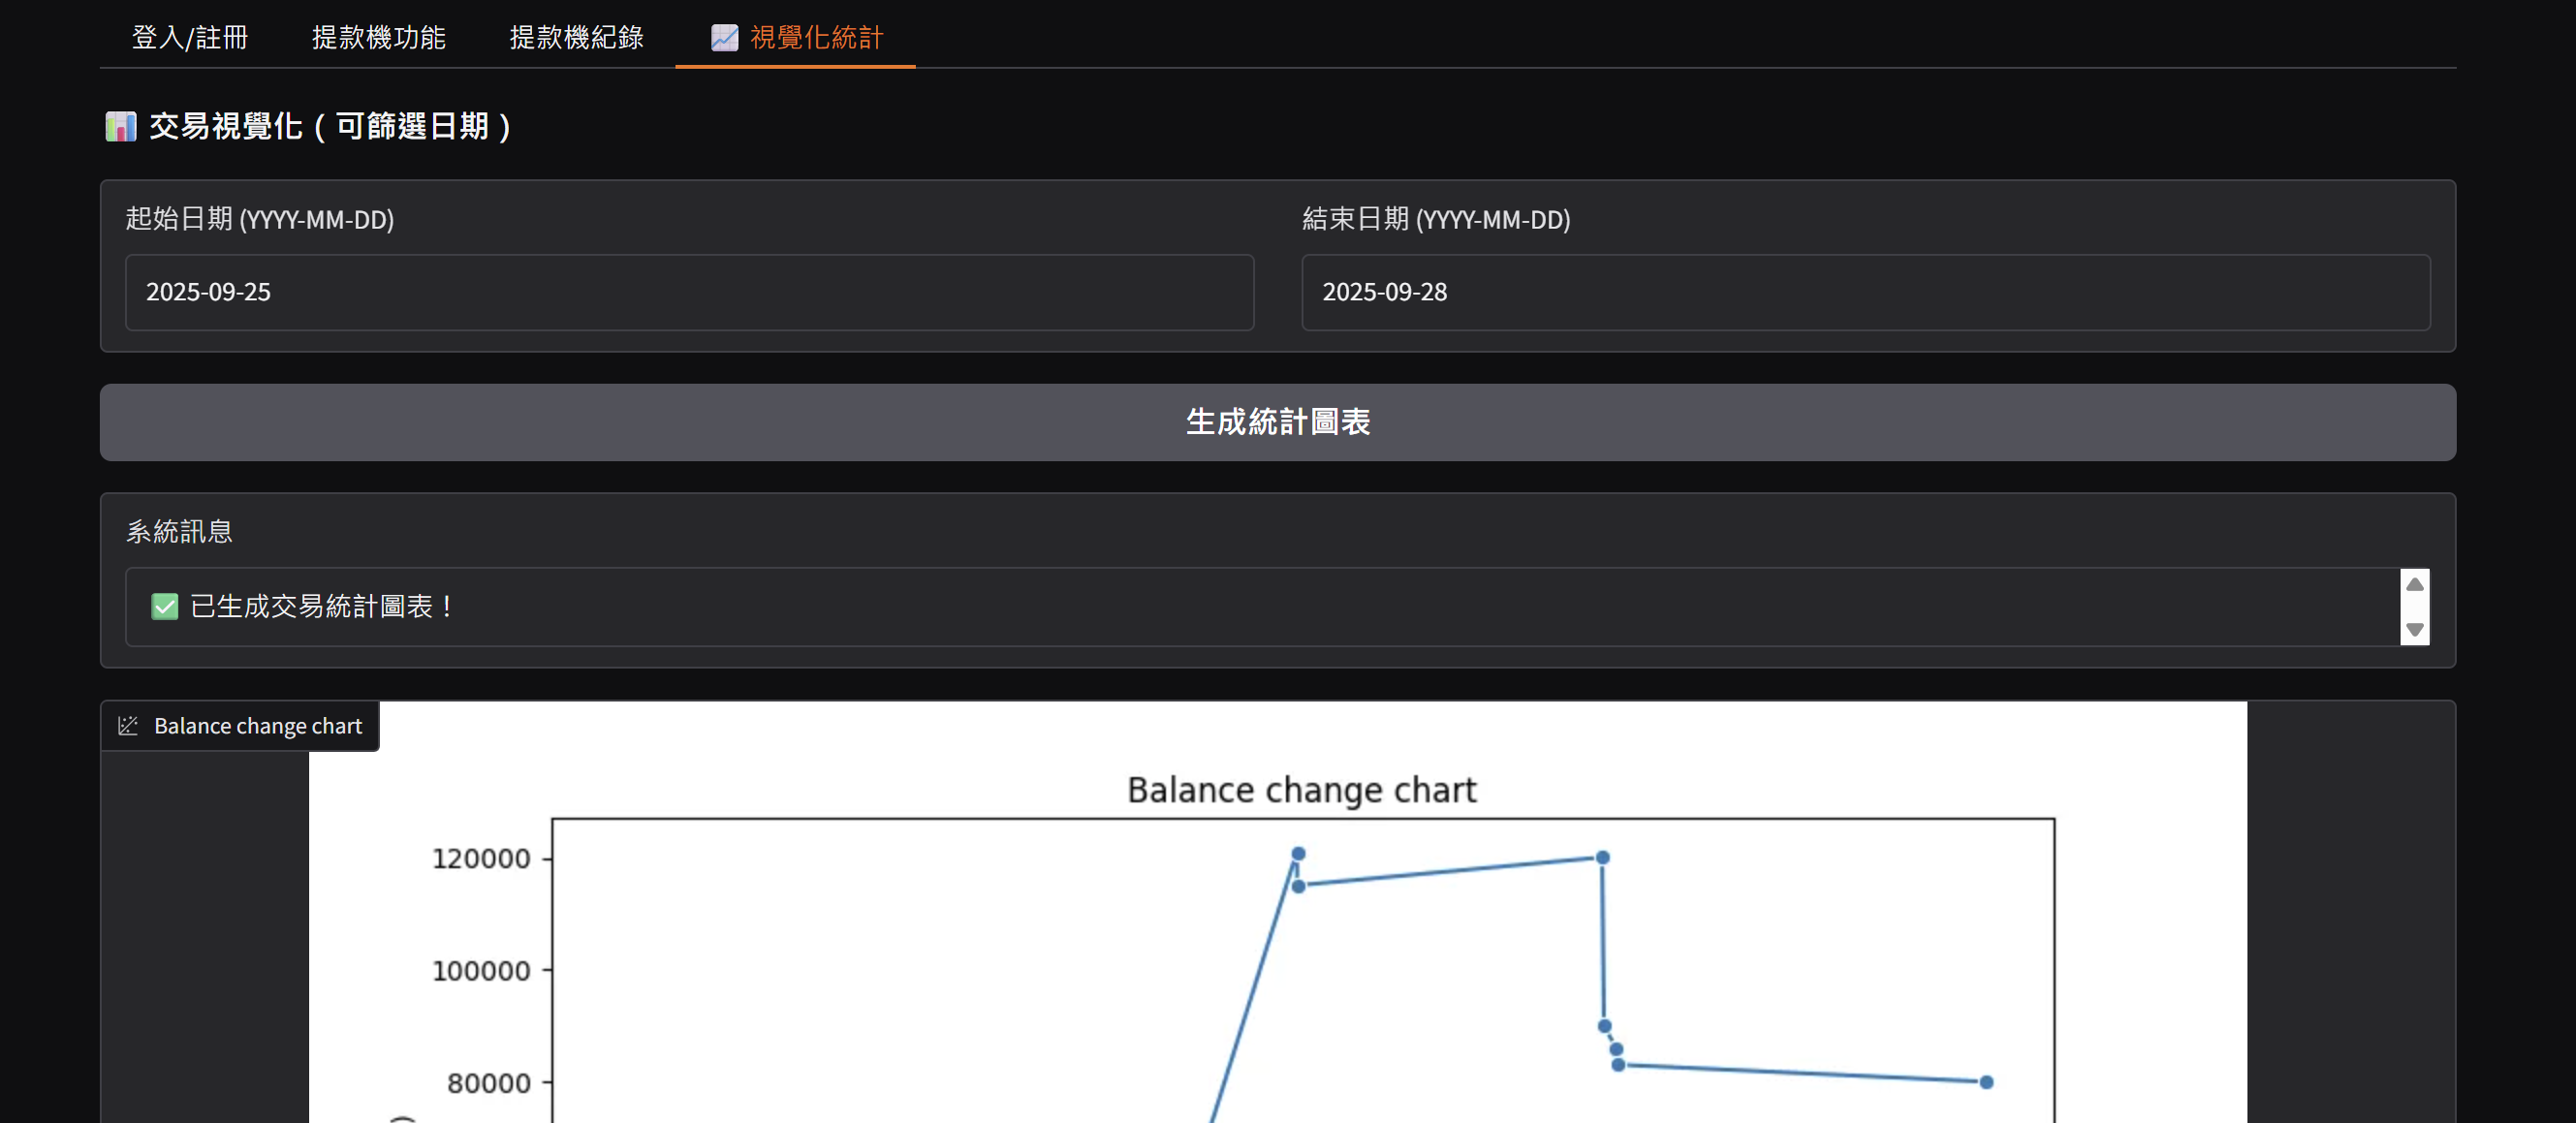
清除紀錄(清除完要記得按刷新紀錄確保清除)
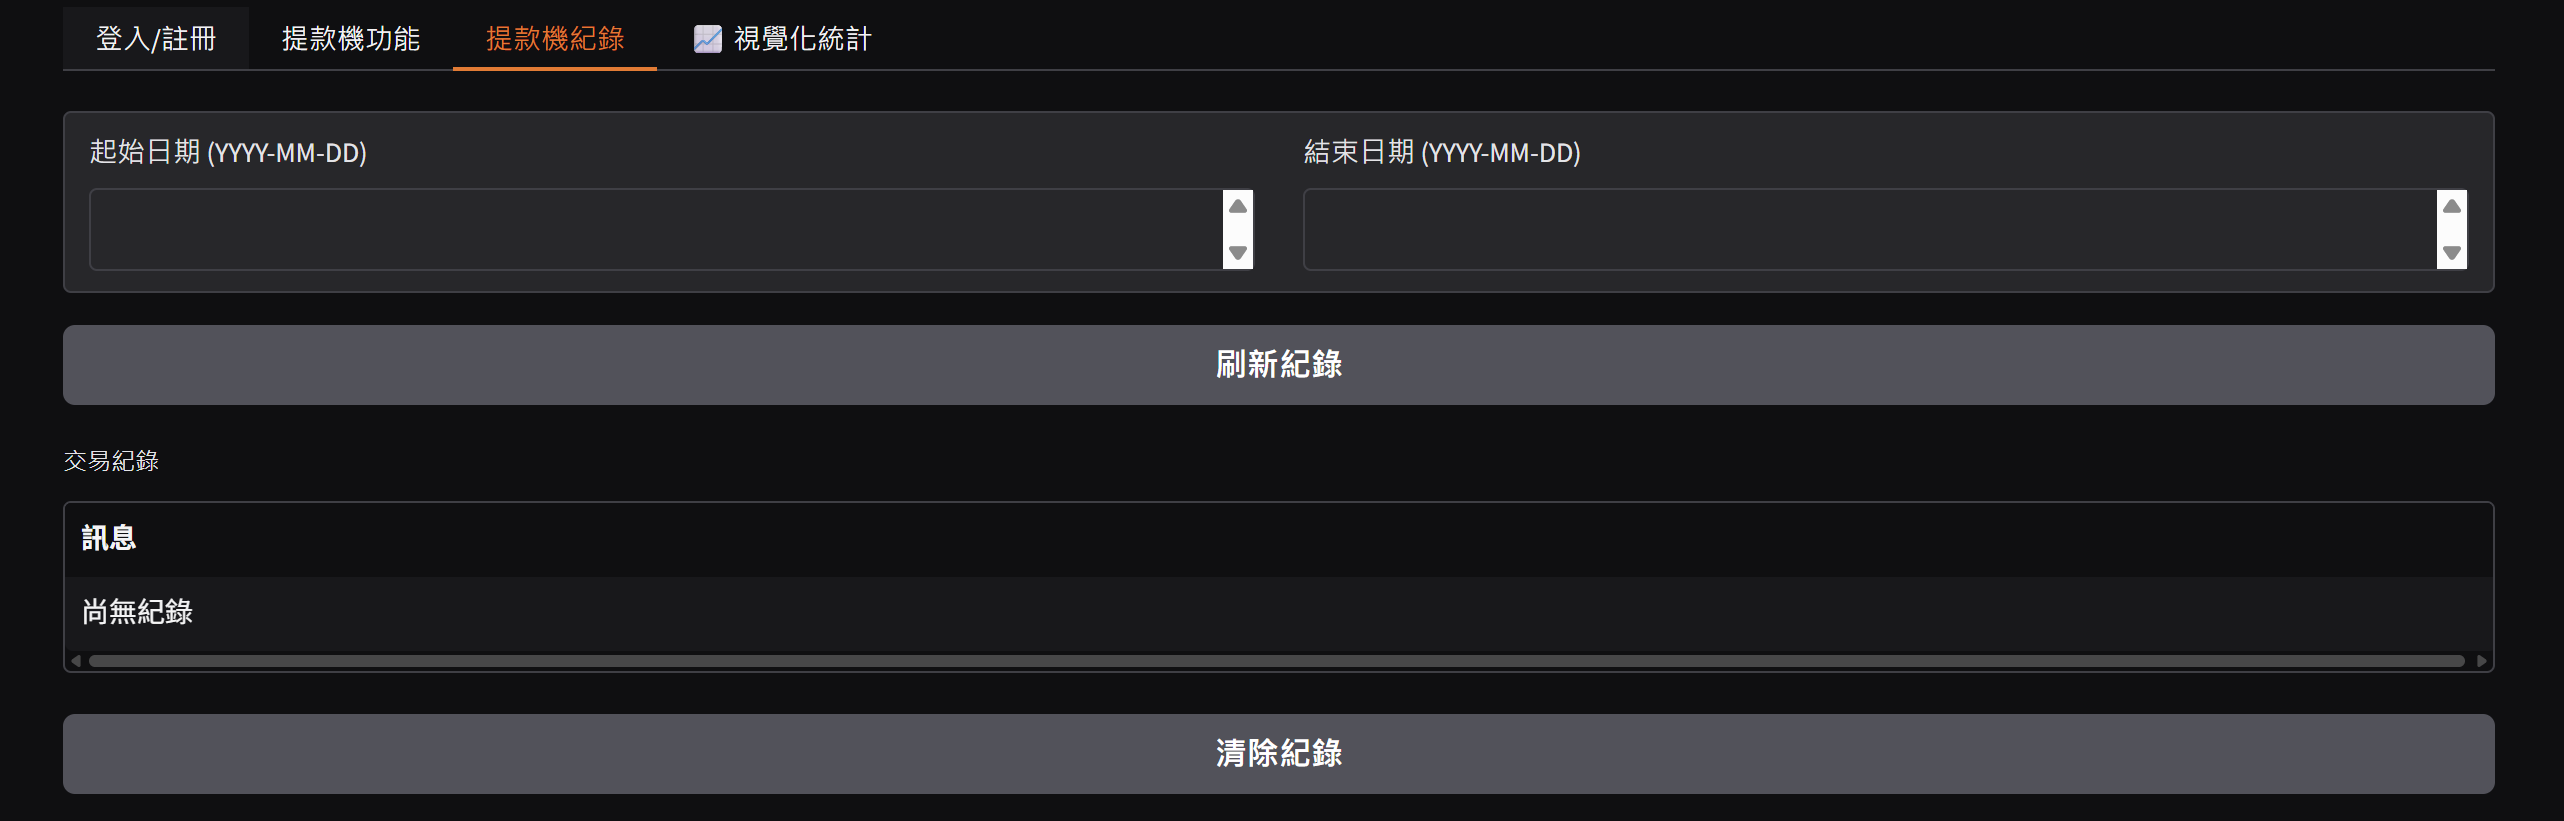